#Mount device#

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
!pwd

/content/drive/MyDrive


#Import#

In [ ]:
from collections import Counter
import re
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import tensorflow as tf

import nltk

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from gensim.models import Word2Vec, KeyedVectors  

# use these to save the model to local
#wv = api.load('word2vec-google-news-300')
#wv.save_word2vec_format('model.bin', binary=True)

#Define Constants#

In [ ]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 100 # max length of each entry (sentence), including padding
EMBEDDING_DIM = 300      # embedding dimensions for word vectors (word2vec/GloVe)

#Load Data#

In [ ]:
train = pd.read_csv('BALANCED.csv') # change to the dataset file
y = train['period'].values
lyrics_train = train['lyrics']
lyrics_train = list(lyrics_train)

labels = [60, 70, 80, 90, 0, 10]

In [ ]:
print(len(lyrics_train))

25077


In [ ]:
texts = [] 

for line in tqdm_notebook(lyrics_train, total=59): 
    if type(line) != float:
      texts.append(line)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/59 [00:00<?, ?it/s]

In [ ]:
print('Sample data:', texts[753], y[753])

Sample data: read news today oh boy lucky man made grade though news rather sad well laugh saw photograph blew mind car notice light changed crowd people stood stared seen face nobody really sure house lord 60.0


#Tokenize#

In [ ]:
for i, ex in enumerate(texts):
  if (type(ex) == float):
    print(i, ex)

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 38607


In [ ]:
print(word_index)

{'love': 1, 'know': 2, 'got': 3, 'like': 4, 'oh': 5, 'na': 6, 'get': 7, 'time': 8, 'go': 9, 'one': 10, 'baby': 11, 'yeah': 12, 'come': 13, 'see': 14, 'want': 15, 'say': 16, 'way': 17, 'let': 18, 'never': 19, 'make': 20, 'day': 21, 'take': 22, 'night': 23, 'back': 24, 'gon': 25, 'feel': 26, 'right': 27, 'cause': 28, 'life': 29, 'thing': 30, 'girl': 31, 'man': 32, 'heart': 33, 'tell': 34, 'need': 35, 'away': 36, 'well': 37, 'wan': 38, 'could': 39, 'think': 40, 'good': 41, 'eye': 42, 'little': 43, 'world': 44, 'said': 45, 'look': 46, 'hey': 47, 'around': 48, 'mind': 49, 'long': 50, 'give': 51, 'keep': 52, 'ooh': 53, 'la': 54, 'still': 55, 'would': 56, 'every': 57, 'hand': 58, 'home': 59, 'light': 60, 'find': 61, 'ever': 62, 'u': 63, 'always': 64, 'hold': 65, 'dream': 66, 'boy': 67, 'people': 68, 'nothing': 69, 'call': 70, 'gone': 71, 'turn': 72, 'head': 73, 'really': 74, 'hear': 75, 'something': 76, 'much': 77, 'new': 78, 'ta': 79, 'old': 80, 'friend': 81, 'put': 82, 'run': 83, 'tonight':

#Padding#

In [ ]:
data = pad_sequences(sequences, padding = 'pre', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (25077, 100)
Shape of label tensor: (25077,)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [ ]:
print(labels)
# convert to one hot encoding 
one_hot_labels = []
for lab in labels:
  lab_arr = [0, 0, 0, 0, 0, 0] #60, 70, 80, 90, 0, 10
  if lab > 50:
    lab_arr[int((lab - 60) / 10)] = 1
  elif lab == 0:
    lab_arr[4] = 1
  else:
    lab_arr[5] = 1

  one_hot_labels.append(lab_arr)

one_hot_labels = np.array(one_hot_labels)
print(one_hot_labels[0])

[70. 80. 70. ...  0. 90. 70.]
[0 1 0 0 0 0]


In [ ]:
print('Tokenized sentences: \n', data[1])
print('Label: \n', labels[1], one_hot_labels[1])

Tokenized sentences: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0  371 1050  532 7263   31   62 1939
  423  807    4  505  157   19 1052 1426  855 2832  855  989   82  250
   48   27  154  121  862  751 2703  134  302   45   62   34    1   16
  295  110]
Label: 
 80.0 [0 0 1 0 0 0]


In [ ]:
print(data.shape)
print(one_hot_labels.shape)

(25077, 100)
(25077, 6)


#Word2Vec#

In [ ]:
embeddings_index = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/model.bin', binary=True)
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in embeddings_index.vocab:
      embedding_vector = embeddings_index[word]
      embedding_matrix[i] = embedding_vector
print(" Completed!")

 Completed!


In [ ]:
print(embedding_matrix)
print(embedding_matrix.shape)

[[ 0.56927424  0.47299069  0.0520592  ...  0.53040849  0.83360228
   0.42960349]
 [ 0.10302734 -0.15234375  0.02587891 ... -0.19824219 -0.12304688
   0.06494141]
 [-0.05493164 -0.1171875   0.02783203 ... -0.18652344  0.15625
  -0.06494141]
 ...
 [ 0.10205078  0.41796875 -0.47460938 ...  0.23339844 -0.10546875
  -0.09423828]
 [ 0.17480469  0.07763672 -0.12597656 ...  0.03515625 -0.16308594
   0.03442383]
 [ 0.29492188  0.265625   -0.11523438 ...  0.24707031 -0.20605469
  -0.07861328]]
(38608, 300)


In [ ]:
print(embeddings_index["oh"])

[ 7.12890625e-02  6.93359375e-02  7.56835938e-02  2.08007812e-01
 -1.22070312e-01  9.88769531e-03 -5.07812500e-02 -2.12890625e-01
  1.06445312e-01  3.22265625e-01 -2.09960938e-01 -1.60156250e-01
 -2.50000000e-01 -9.61914062e-02  4.78515625e-02  3.63281250e-01
  1.66015625e-01  1.34765625e-01 -2.02636719e-02 -5.90820312e-02
 -9.22851562e-02  4.95605469e-02  4.45312500e-01 -1.25976562e-01
  1.66015625e-01  1.31835938e-01 -8.93554688e-02  3.85742188e-02
  5.34667969e-02 -1.62109375e-01  1.44531250e-01  2.27539062e-01
 -1.52343750e-01  6.34765625e-02 -1.20117188e-01  1.35742188e-01
  7.86132812e-02  5.07812500e-02  2.10937500e-01  2.79296875e-01
  9.81445312e-02 -1.59179688e-01  3.82812500e-01 -4.68750000e-02
  1.38671875e-01 -3.66210938e-02  9.08203125e-02  7.37304688e-02
 -5.17578125e-02 -3.05175781e-02 -2.73437500e-01  2.51464844e-02
  1.47460938e-01  1.84570312e-01  8.36181641e-03  1.21093750e-01
 -1.11328125e-01  1.14257812e-01  1.34765625e-01  1.02050781e-01
 -1.14257812e-01  1.55273

In [ ]:
# Converting our labels into numpy arrays
lyrics = np.array(data)
labels = np.array(one_hot_labels)

In [ ]:
print(lyrics[:20])
print(labels[:20])

[[    0     0     0 ...   117   576   477]
 [    0     0     0 ...    16   295   110]
 [    0     0     0 ...   267     2   147]
 ...
 [    0     0     0 ...  1697 25375  1081]
 [    0     0     0 ...  1519   142    76]
 [    0     0     0 ...   144   838   699]]
[[0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]]


#Partition the Data (train, val, test)#

In [ ]:
split_frac = 0.7 # 70% train, 30% test(val + test)
split_id = int(split_frac * len(lyrics))
train_lyrics, test_lyrics = lyrics[:split_id], lyrics[split_id:]
train_labels, test_labels = labels[:split_id], labels[split_id:]

In [ ]:
print(train_labels.shape)
print(train_lyrics.shape)

(17553, 6)
(17553, 100)


In [ ]:
split_frac = 0.5 # 50% validation, 50% test
split_id = int(split_frac * len(test_lyrics))
val_lyrics, test_lyrics = test_lyrics[:split_id], test_lyrics[split_id:]
val_labels, test_labels = test_labels[:split_id], test_labels[split_id:]

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

train_data = TensorDataset(torch.from_numpy(train_lyrics), torch.from_numpy(train_labels))
val_data = TensorDataset(torch.from_numpy(val_lyrics), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_lyrics), torch.from_numpy(test_labels))

batch_size = 32  #lower
hidden = 128
epochs = 30 # increase
lr=0.0001

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
class SentimentNet(nn.Module):
    def __init__(self,
                 weight_matrix=None,
                 vocab_size=None, 
                 output_size=1,  
                 hidden_dim=512,
                 embedding_dim=400, 
                 n_layers=1, 
                 dropout_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        # initialize the representation to pass to the LSTM
        self.embedding, embedding_dim = self.init_embedding(
            vocab_size, 
            embedding_dim, 
            weight_matrix)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=dropout_prob, batch_first=True)
        # dropout
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.Softmax(dim = -1)
        
    def forward(self, x, hidden):
        # forward pass of the network
        batch_size = x.size(0)
        # transform input
        embeds = self.embedding(x)
        # run input embedding + hidden state through model
        lstm_out, hidden = self.lstm(embeds, hidden)
        # reshape
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        # dropout certain pct of connections
        out = self.dropout(lstm_out)
        # fully connected layer
        out = self.fc(out)
        # connect to 6 outputs (one_hot_encoding)
        # activation function
        out = self.softmax(out)
        # reshape
        out = out.view(batch_size, int(out.shape[0] / batch_size), out.shape[1])
        out = out[:,-1]
        # return the output and the hidden state
        return out, hidden, lstm_out
    
    def init_embedding(self, vocab_size, embedding_dim, weight_matrix):
        # initializes the embedding
        if weight_matrix is None:
            if vocab_size is None:
                raise ValueError('If no weight matrix, need a vocab size')
            # if embedding is a size, initialize trainable
            return(nn.Embedding(vocab_size, embedding_dim),
                   embedding_dim)
        else:
            # otherwise use matrix as pretrained
            weights = torch.FloatTensor(weight_matrix)
            return(nn.Embedding.from_pretrained(weights),
                  weights.shape[1])
    
    def init_hidden(self, batch_size):
        # initializes the hidden state
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))
        return hidden

In [ ]:
model_params = {'weight_matrix': embedding_matrix,
                'vocab_size': len(word_index) + 1,
               'output_size': 6,
               'hidden_dim': hidden,
               'n_layers': 2,
               'embedding_dim': EMBEDDING_DIM}
               #'dropout_prob': y}
model = SentimentNet(**model_params)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
counter = 0
print_every = 10
clip = 5
valid_loss_min = np.Inf

model.train()

train_losses = []
val_losses = []
train_acc = []
val_acc = []

for i in range(epochs):
    print("Epoch")
    h = model.init_hidden(batch_size)
    train_correct = 0
    val_correct = 0
    calculated = 0
    train_loss = []
    val_loss = []
    train_count = 0
    val_count = 0

    periods = [0, 0, 0, 0, 0, 0]
    periods_gt = [0, 0, 0, 0, 0, 0]
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h, lstm_out = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())

        train_loss.append(loss.item())

        for j, ex in enumerate(output):
          train_count += 1
          gt_label = torch.argmax(labels[j].float()) 
          pred_label = torch.argmax(ex.squeeze())

          periods[pred_label] += 1
          periods_gt[gt_label] += 1

          if pred_label.eq(gt_label):
            train_correct += 1

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    val_h = model.init_hidden(batch_size)
    model.eval()

    for inp, lab in val_loader:
        val_h = tuple([each.data for each in val_h])
        inp, lab = inp.to(device), lab.to(device)
        out, val_h, _ = model(inp, val_h)
        loss_val = criterion(out.squeeze(), lab.float())

        val_loss.append(loss_val.item())

        for j, ex in enumerate(out):
          val_count += 1
          gt_label = torch.argmax(lab[j].float()) 
          pred_label = torch.argmax(ex.squeeze())

          if pred_label.eq(gt_label):
            val_correct += 1
        
    model.train()

    print("Epoch: {}/{}".format(i+1, epochs),
          "Loss: {:.6f}".format(np.mean(train_loss)),
          "Val Loss: {:.6f}".format(np.mean(val_loss)),
          "Acc: {:.6f}".format(train_correct/train_count),
          "Val Acc: {:.6f}".format(val_correct/val_count))
    print(train_correct)
    print(train_count)
    
    if np.mean(val_loss) <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict_' + str(EMBEDDING_DIM) + '.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model.'.format(valid_loss_min,np.mean(val_loss)))
        valid_loss_min = np.mean(val_loss)

    train_losses.append(np.mean(train_loss))
    val_losses.append(np.mean(val_loss))
    train_acc.append(train_correct/train_count)
    val_acc.append(val_correct/val_count)
    print(periods)
    print(periods_gt)

Epoch
Epoch: 1/30 Loss: 1.791758 Val Loss: 1.791632 Acc: 0.163207 Val Acc: 0.165331
2862
17536
Validation loss decreased (inf --> 1.791632).  Saving model.
[108, 386, 23, 7220, 1796, 8003]
[2888, 2911, 2965, 2931, 2937, 2904]
Epoch
Epoch: 2/30 Loss: 1.762202 Val Loss: 1.745553 Acc: 0.236770 Val Acc: 0.256143
4152
17536
Validation loss decreased (1.791632 --> 1.745553).  Saving model.
[6711, 832, 362, 642, 873, 8116]
[2884, 2909, 2964, 2933, 2941, 2905]
Epoch
Epoch: 3/30 Loss: 1.738917 Val Loss: 1.729980 Acc: 0.267279 Val Acc: 0.283387
4687
17536
Validation loss decreased (1.745553 --> 1.729980).  Saving model.
[5322, 3370, 1264, 17, 2390, 5173]
[2888, 2912, 2959, 2932, 2942, 2903]
Epoch
Epoch: 4/30 Loss: 1.731367 Val Loss: 1.731574 Acc: 0.278684 Val Acc: 0.273771
4887
17536
[4830, 3120, 2706, 5, 2556, 4319]
[2888, 2909, 2963, 2935, 2938, 2903]
Epoch
Epoch: 5/30 Loss: 1.725142 Val Loss: 1.734074 Acc: 0.284044 Val Acc: 0.268964
4981
17536
[4448, 3014, 3357, 8, 2615, 4094]
[2887, 2912, 29

In [ ]:
 # Loading the best model
model.load_state_dict(torch.load('./state_dict_' + str(EMBEDDING_DIM) + '.pt'))

test_losses = []
periods = [0, 0, 0, 0, 0, 0]
gt_periods = [0, 0, 0, 0, 0, 0]
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h, _ = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    for i, ex in enumerate(output):
      gt_label = torch.argmax(labels[i].float()) 
      pred_label = torch.argmax(ex.squeeze())

      periods[pred_label] += 1
      gt_periods[gt_label] += 1

      if pred_label.eq(gt_label):
        num_correct += 1

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))
print(num_correct)
print(len(test_loader.dataset))
print(periods)
print(gt_periods)

Test loss: 1.709
Test accuracy: 0.302
1136
3762
[783, 838, 864, 212, 450, 597]
[596, 646, 582, 658, 634, 628]


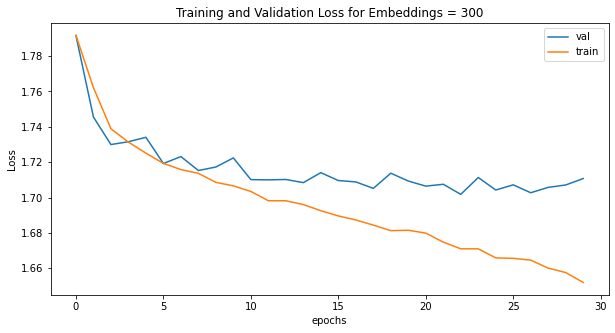

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 


plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss for Embeddings = " + str(EMBEDDING_DIM))
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("word2vec_loss_" + str(epochs)+"_"+ str(batch_size) + "_" + str(lr)+ "_" + str(EMBEDDING_DIM) + "_" + str(hidden) + ".jpg")
plt.show()

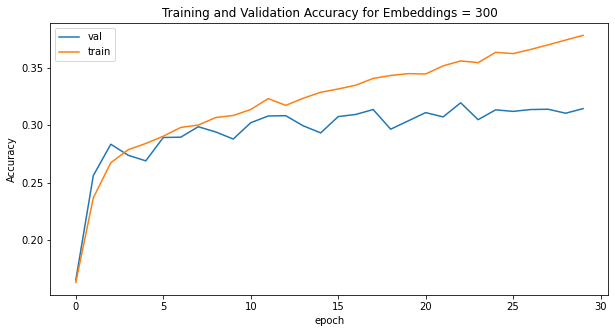

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy for Embeddings = " + str(EMBEDDING_DIM))
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("word2vec_acc_" + str(epochs)+"_"+ str(batch_size) + "_" + str(lr)+ "_" + str(EMBEDDING_DIM) + "_" + str(hidden) + ".jpg")
plt.show()